In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as ss
import powerlaw

In [2]:
%matplotlib notebook
sns.set_style('darkgrid')

In [3]:
g_names = ['15_0', '15_50', '15_100', '15_150', '15_200', '16_0', '16_50', '16_100', '16_150',
             '16_200', '17_0', '17_50', '17_100', '17_150', '17_200', '18_0', '18_50', '18_100', 
             '18_150', '18_200']


In [129]:
'''create data frames for each dist per configuration'''
dfs = list()

for i in range(len(g_names)):
    
    dfs.append(pd.read_csv('/home/acer/Degrees/deg_%s.csv' %g_names[i]))


In [131]:
for d in range(len(dfs)):
    dfs[d] = dfs[d].drop('Unnamed: 0', axis=1)

In [132]:
def get_means_cis(L_dfs):
    
    '''Create a dictionary for the keys with their associated values  '''
    new_L_dfs = list()
    
    for df in (L_dfs):
    
        keys = df.alist.unique()
        monotonic_index = pd.Index(df['alist'])
        degree_dist = {}

        for key in keys:
            inds = monotonic_index.get_loc(key)
            x = df['Deg_list'][inds]
            degree_dist[key] = (np.quantile(x, 0.025), x.mean(), np.quantile(x, 0.975))

        Degree = list(degree_dist.keys())
        Freq = np.asarray(list(degree_dist.values()))
        Ci_lower = np.asarray([x[0] for x in Freq])
        Means = np.asarray([x[1] for x in Freq])
        Ci_upper = np.asarray([x[2] for x in Freq])

        data = {'Degree': Degree, 'Ci_lower':Ci_lower, 'Means': Means,
           'Ci_upper': Ci_upper}

        df2 = pd.DataFrame(data, columns=['Degree', 'Ci_lower', 'Means', 'Ci_upper'])

        zero_index = df2.index[pd.Index(df2['Means']).get_loc(0) == True].tolist()

        df3 = df2.drop(zero_index, axis=0)
        
        new_L_dfs.append(df3)
    return new_L_dfs

In [133]:
dfs_means = get_means_cis(dfs)

In [134]:
dfs_means[2].sample(5)

,Degree,Ci_lower,Means,Ci_upper
70,71,0.0,0.000132,0.001369
110,111,0.0,0.000249,0.002055
38,39,0.0,0.000733,0.005436
42,43,0.0,0.000134,0.002693
98,99,0.0,0.000182,0.001586


In [135]:
dfs[3].sample(5)

,alist,Deg_list
3235,32,0.000000
2574,162,0.000000
3052,107,0.000000
2634,48,0.000000
2357,14,0.017341


In [100]:
fit = powerlaw.Fit(dfs_means[2]['Means'], discrete=True)

Calculating best minimal value for power law fit
/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [101]:
xmin, alpha, sigma = fit.xmin, fit.alpha, fit.sigma
print(xmin, alpha, sigma)

0.0787641860055912 1.3138614072809833 0.1403630884388052


<IPython.core.display.Javascript object>


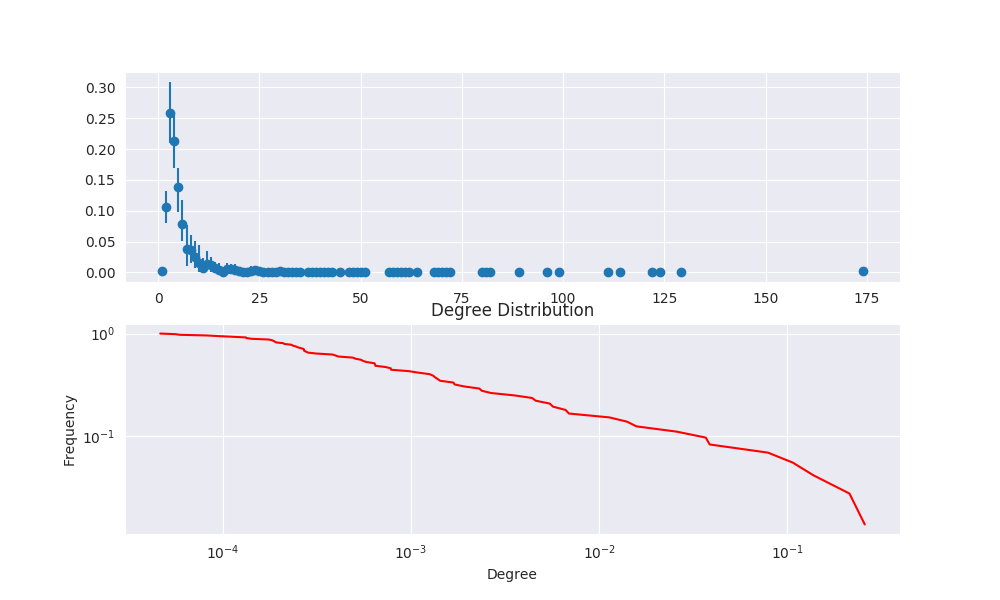

In [102]:
plt.figure(1, figsize=(10,6))
plt.subplot(211)
y = dfs_means[2]
lines = plt.errorbar(y['Degree'], y['Means'], xerr=0.5,
                    yerr=[y['Means'] - y['Ci_lower'],
                    dfs_means[2]['Ci_upper'] - y['Means']],
                    linestyle='',fmt='o')

plt.subplot(212)
powerlaw.plot_ccdf(y['Means'], color='r' )
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [14]:
log_degree = np.log(y['Degree'])
log_means = np.log(y['Means'])
log_Ci_lower = np.log(y['Ci_lower'])
np.log_Ci_upper = np.log(y['Ci_upper'])

/home/acer/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<IPython.core.display.Javascript object>


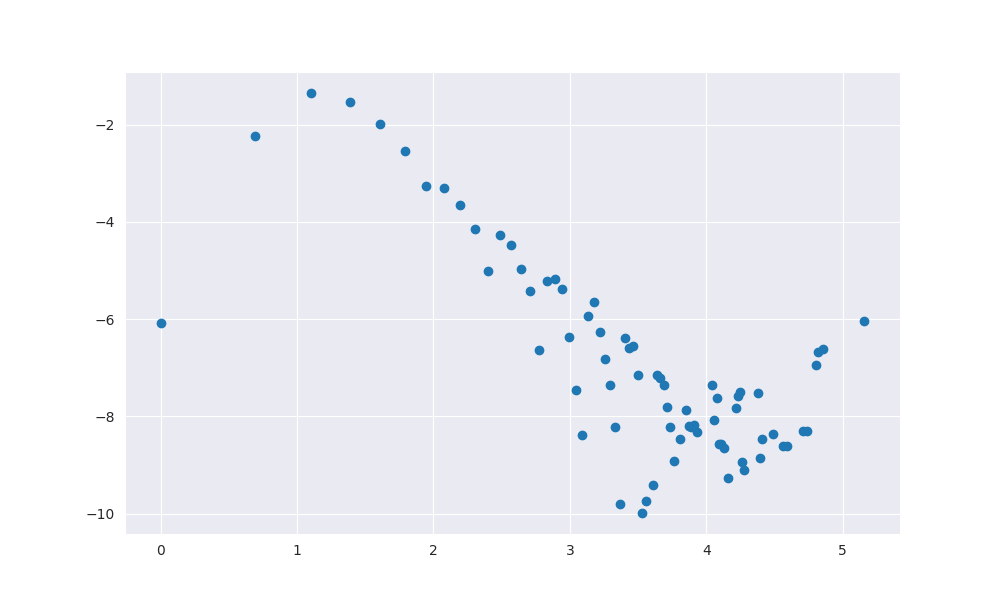

In [15]:
plt.figure(2, figsize=(10,6))
lines = plt.scatter(log_degree, log_means)
plt.show()

In [14]:
from statsmodels.formula.api import ols

In [15]:
dflog = np.log(dfs_means[3][['Degree', 'Means']])
model = ols('Means ~ Degree', data = dflog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Means   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     101.5
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           4.02e-15
Time:                        12:15:09   Log-Likelihood:                -115.73
No. Observations:                  70   AIC:                             235.5
Df Residuals:                      68   BIC:                             240.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6850      0.522     -3.227      0.002      -2.727      -0.643
Degree        -1.4455      0.143    -10.075      0.000      -1.732      -1.159
==============================================================================
Omnibus:                        7.185   Durbin-Watson:                   0.775
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.696
Skew:                          -0.591   Prob(JB):                       0.0352
Kurtosis:                       3.947   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
Means_hat = np.exp(xmin) * dfs_means[2][['Degree']]**(-alpha)

In [107]:
dfs_means[2].insert(loc=3, value = Means_hat, column='Means_hat')

ValueError: cannot insert Means_hat, already exists

<IPython.core.display.Javascript object>


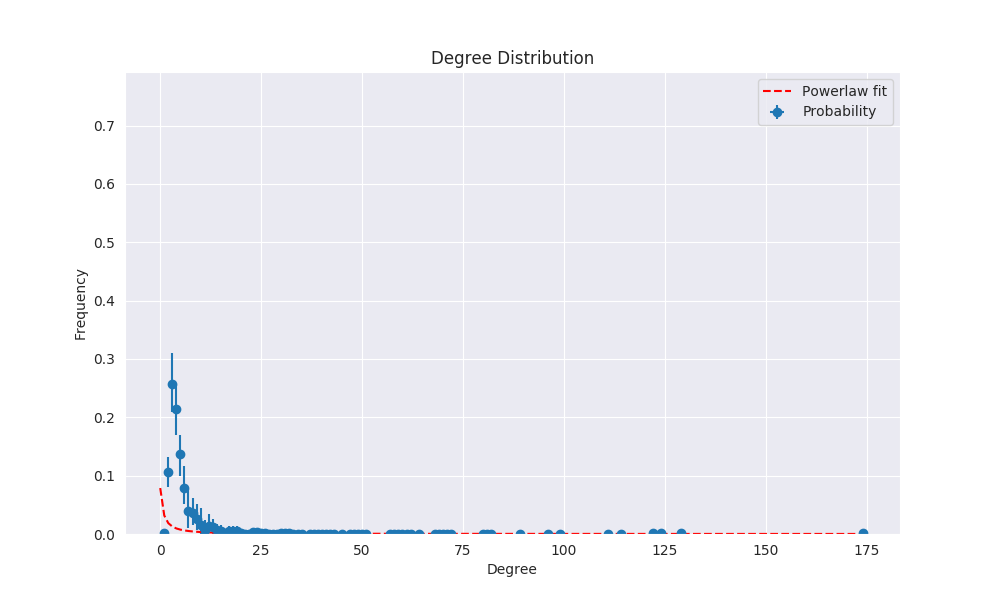

In [108]:
plt.figure(3, figsize=(10,6))
lines = plt.errorbar(dfs_means[2]['Degree'], dfs_means[2]['Means'], xerr=0.5,
                    yerr=[dfs_means[2]['Means'] - dfs_means[2]['Ci_lower'],
                    dfs_means[2]['Ci_upper'] - dfs_means[2]['Means']],
                    linestyle='',fmt='o', label='Probability')


plt.plot(dfs_means[2]['Means_hat'], color='r', linestyle='--', label='Powerlaw fit')
#plt.plot(fit.xmins, fit.Ds, color='g', label='Uncertainty xmin')
#plt.plot(fit.alphas, fit.Ds, color='violet' , label='Uncertainty alpha')
plt.ylim(0, max(fit.sigmas))
plt.legend()
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [19]:
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio = True)
print(R, p)

-3.5437680063046093 0.0003944521734525682


/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [125]:
def get_xmin_and_alpha_dist(dfs_list):
    '''In this function we will get the distribution of xmin and alpha per degree conf for 50 runs
    i.e. only the best xmin will be retained for each run and in total the number of xmins and alphas
    will be 50. This function will be applied for 20 confiugrations and then we will make the box plot in
    another function for both xmins and alphas'''
    xmins_dist, alphas_dist, new_dfs = list(), list(), list()
    
    for i in range(len(dfs_list)):
    
    #getting the splits of the df based on the number of runs
        inds_1 = dfs_list[i].index[pd.Index(dfs_list[i]['alist']).get_loc(1) == True].tolist()
    # Adding the last range in the list 
        inds_1.append(dfs_list[i].shape[0])
    # Creating list of dfs for the number of runs 
        l_mod = [0] + inds_1 + [max(inds_1) +1]
        list_of_dfs = [dfs_list[i].iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]
    # Removing first and last dfs cuz they're empty
        del(list_of_dfs[0], list_of_dfs[-1])
    
        xmins_, alphas_ = list(), list()
    
        for i in range(0, len(list_of_dfs)):
            x = list_of_dfs[i]['Deg_list']
            fit_ = powerlaw.Fit(x, discrete=True)
            xmin = fit_.xmin
            alpha = fit_.alpha
            xmins_.append(xmin)
            alphas_.append(alpha)
            
        xmins_dist.append(xmins_)
        alphas_dist.append(alphas_)
        new_dfs.append(list_of_dfs)
        
    return xmins_dist, alphas_dist, list_of_dfs


In [126]:
xmins_all, alphas_all, dfs_final = get_xmin_and_alpha_dist(dfs)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Thro

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
/home/acer/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Thro

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

In [9]:
groupby_dict = {'15_0': '15', '15_50':'15', '15_100':'15', '15_150':'15', '15_200':'15',
               '16_0':'16', '16_50':'16', '16_100':'16', '16_150':'16', '16_200':'16',
               '17_0':'17', '17_50':'17', '17_100':'17', '17_150':'17', '17_200':'17',
               '18_0':'18', '18_50':'18', '18_100':'18', '18_150':'18', '18_200':'18'}

In [10]:
xmins_df = pd.DataFrame(xmins_all)
xmins_df = xmins_df.transpose()
xmins_df.columns = g_names

NameError: name 'xmins_all' is not defined

In [11]:
import itertools
lst = range(15,19)
lst2 = [0, 50, 100, 150, 200]
age = list(itertools.chain.from_iterable(itertools.repeat(x, 250) for x in lst))
cd4 = list(itertools.chain.from_iterable(itertools.repeat(x, 50) for x in lst2))

In [12]:
cd4_group = list(itertools.chain.from_iterable(itertools.repeat(cd4, 4)))

In [13]:
grouped_df = pd.DataFrame(xmins_df.groupby(groupby_dict, axis=1, as_index=True))

NameError: name 'xmins_df' is not defined

In [31]:
melted_xmin = pd.melt(xmins_df)

In [32]:
melted_xmin['Age'] = age

In [33]:
melted_xmin['Cd4'] = cd4_group

In [23]:
xmins_r = pd.read_csv('/home/acer/Stats/xmins.csv')

In [24]:
xmins_r_melted = pd.melt(xmins_r)

In [25]:
xmins_r_melted['Age'] = age
xmins_r_melted['Cd4'] = cd4_group

In [26]:
xmins_r_melted.head(5)

,variable,value,Age,Cd4
0,15_0,3,15,0
1,15_0,4,15,0
2,15_0,4,15,0
3,15_0,3,15,0
4,15_0,5,15,0


In [29]:
alphas_r = pd.read_csv('/home/acer/Stats/alphas.csv')
alphas_r_melted = pd.melt(alphas_r)

In [30]:
alphas_r_melted['Age'] = age
alphas_r_melted['Cd4'] = cd4_group

<IPython.core.display.Javascript object>


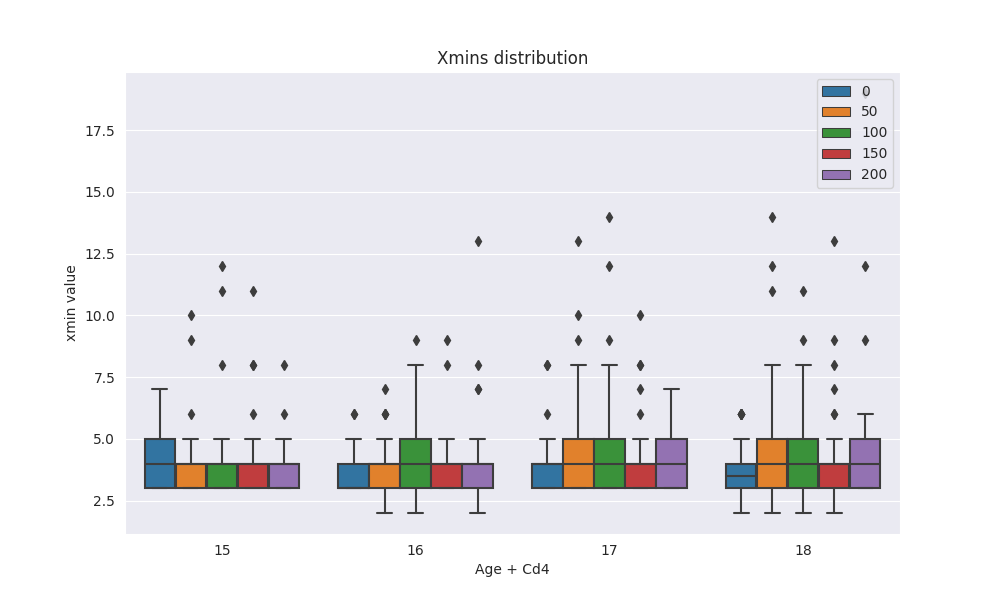

In [31]:
plt.figure(70, figsize=(10, 6))
sns.boxplot(data=xmins_r_melted, x='Age', y='value', hue='Cd4')
plt.title('Xmins distribution')
plt.xlabel('Age + Cd4')
plt.ylabel('xmin value')
plt.legend(loc='upper right')
plt.show()

In [54]:
# alphas_df = pd.DataFrame(alphas_all)
# alphas_df = alphas_df.transpose()
# alphas_df.columns = g_names

In [55]:
alphas_melted = pd.melt(alphas_df)

In [56]:
alphas_melted['Age'] = age
alphas_melted['Cd4'] = cd4_group

<IPython.core.display.Javascript object>


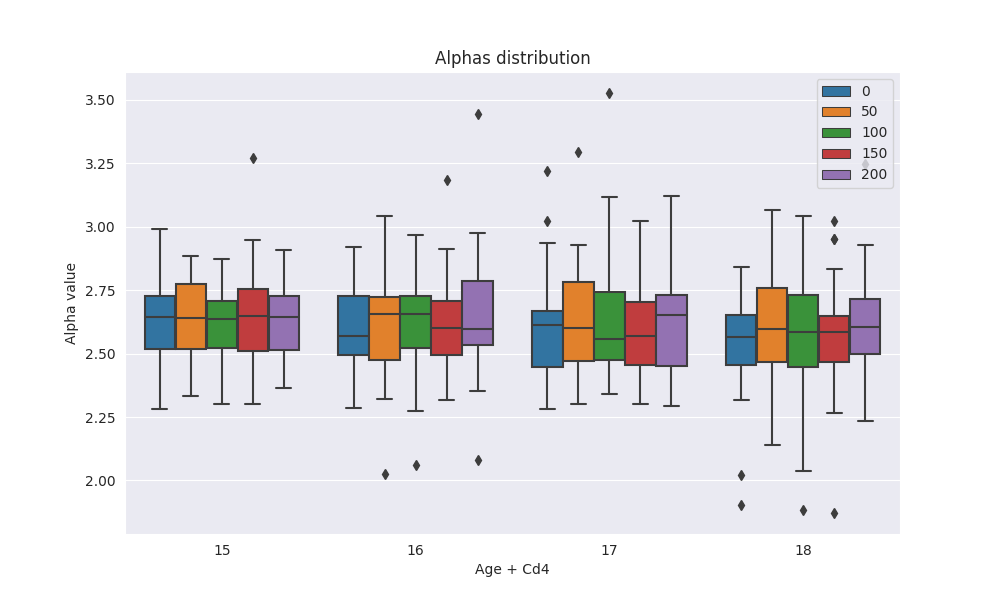

In [33]:
plt.figure(73, figsize=(10,6))
sns.boxplot(data=alphas_r_melted, x='Age', y='value', hue='Cd4')
plt.title('Alphas distribution')
plt.xlabel('Age + Cd4')
plt.ylabel('Alpha value')
plt.legend(loc='upper right')
#plt.ylim(1, 2)
plt.show()

In [121]:
dfs[0]

,alist,Deg_list
Unnamed: 0,,
1,1,0.000000
2,2,0.119617
3,3,0.258373
4,4,0.224880
5,5,0.090909
...,...,...
3866,66,0.000000
3867,67,0.000000
3868,68,0.000000


In [83]:
xmins_ = xmins_r.T.values[0]
df_x = dfs[0].alist
df_y = dfs[0].Deg_list
alphas_ = alphas_r.T.values[0]

In [89]:
df_y

Unnamed: 0
1       0.000000
2       0.119617
3       0.258373
4       0.224880
5       0.090909
          ...   
3866    0.000000
3867    0.000000
3868    0.000000
3869    0.000000
3870    0.005376
Name: Deg_list, Length: 3870, dtype: float64

20

In [56]:
def plot_deg_dist(dfs_list, xmin_list, alpha_list):
    
    for i in range(len(dfs_list)):
        
        for j in range(50)
            Degree = dfs_list[i][j].alist
            d_dist = dfs_list[i][j].Deg_list
            alpha_ = alpha_list[i][j]
            xmin_ = xmin_list[i][j]
            y_hat = xmin_ *(Degree**(-alpha_))
            
            plt.figure(j + 7, figsizse(10, 6))
            plt.scatter(Degree, d_dist, color='b', label='Prob')
            plt.plot(Degree, y_hat, color='r', label='Powerlaw fit')
            plt.title('Degree Distribution')
            plt.legend()
            plt.xlabel('Degree')
            plt.ylabel('Probability')
            plt.legend()
            plt.show()
#         degree_hat = xmin_list[i] * (deg_list[i].alist**(-alpha_list[i]))
#         plt.figure(i+7, figsize=(10, 6))
#         plt.scatter(deg_list[i]['alist'], deg_list[i]['Deg_list'], color='b', label='Prob')
#         plt.plot(deg_list[i]['alist'], degree_hat, color='r', label='Powerlaw fit')
#         plt.title('Degree_distribution')
#         plt.xlabel('Degree')
#         plt.ylabel('Frequency')
#         plt.legend()
#         plt.show()

        
# Uncomment the below line to plot all of them
#plot_deg_dist(list_of_dfs, xmin_list=xmins, alpha_list=alphas)

In [110]:
xmins_r_list = xmins_r.T.values.tolist()
alphas_r_list = alphas_r.T.values.tolist()

In [111]:
plot_deg_dist(dfs, xmin_list=xmins_r_list, alpha_list=alphas_r_list)

TypeError: bad operand type for unary -: 'list'

In [17]:
'''Next thing, we will plot boxplots of graph statistics'''

trans_all = pd.read_csv('/home/acer/Stats/Trans.csv')
density_all = pd.read_csv('/home/acer/Stats/Density.csv')
centrality_all = pd.read_csv('/home/acer/Stats/Centrality.csv')
Gsizes_all = pd.read_csv('/home/acer/Stats/Gsize.csv')

In [18]:
trans_all = trans_all.drop('Unnamed: 0', axis=1)

In [19]:
density_all = density_all.drop('Unnamed: 0', axis=1)
centrality_all = centrality_all.drop('Unnamed: 0', axis=1)

In [20]:
Gsizes_all = Gsizes_all.drop('Unnamed: 0', axis=1)

In [21]:
trans_all.columns = [''] * 20
density_all.columns = [''] * 20
centrality_all.columns = [''] * 20
Gsizes_all.columns = [''] * 20

In [22]:
'''After removing column names from the dfs, we add the new ones here'''
trans_all.columns = g_names
density_all.columns = g_names
centrality_all.columns = g_names
Gsizes_all.columns = g_names

In [23]:
trans_all.head(5)

,15_0,15_50,15_100,15_150,15_200,16_0,16_50,16_100,16_150,16_200,17_0,17_50,17_100,17_150,17_200,18_0,18_50,18_100,18_150,18_200
0,0.000000,0.000000,0.019062,0.019167,0.005767,0.016037,0.018182,0.032385,0.015489,0.000000,0.013889,0.024225,0.025475,0.016970,0.031250,0.009506,0.017778,0.016181,0.000000,0.031746
1,0.018298,0.022222,0.023029,0.006510,0.023569,0.020000,0.014493,0.009456,0.023810,0.019957,0.017764,0.021138,0.015432,0.013072,0.000000,0.033592,0.020833,0.021505,0.015625,0.022876
2,0.027778,0.009662,0.022523,0.019364,0.024133,0.011719,0.010192,0.021212,0.012658,0.012821,0.031170,0.044118,0.035121,0.008000,0.024715,0.000000,0.000000,0.011364,0.000000,0.000000
3,0.030071,0.012531,0.030441,0.044643,0.045455,0.010294,0.000000,0.004717,0.025516,0.006289,0.000000,0.013109,0.026585,0.007143,0.006494,0.023050,0.000000,0.027871,0.004367,0.032073
4,0.000000,0.031618,0.000000,0.006472,0.008190,0.000000,0.024155,0.020964,0.019608,0.023173,0.022265,0.020540,0.005181,0.005000,0.005848,0.021212,0.010471,0.033715,0.017460,0.013591


In [24]:
trans_melted = pd.melt(trans_all)
trans_melted['Age'] = age
trans_melted['Cd4'] = cd4_group
density_melted = pd.melt(density_all)
density_melted['Age'] = age
density_melted['Cd4'] = cd4_group
centrality_melted = pd.melt(centrality_all)
centrality_melted['Age'] = age
centrality_melted['Cd4'] = cd4_group
Gsizes_melted = pd.melt(Gsizes_all)
Gsizes_melted['Age'] = age
Gsizes_melted['Cd4'] = cd4_group

<IPython.core.display.Javascript object>


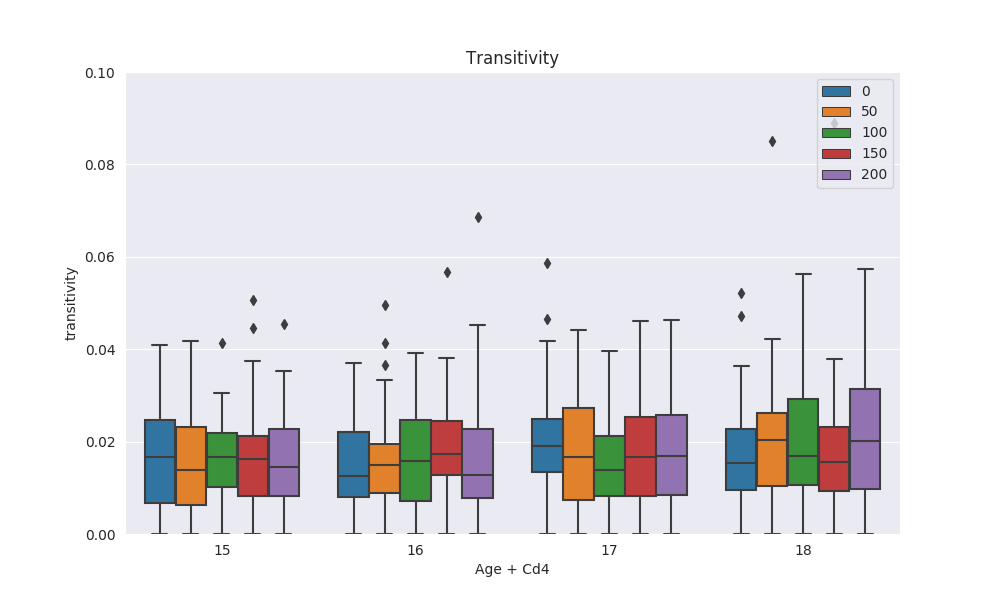

In [77]:
plt.figure(74, figsize=(10, 6))
sns.boxplot(data=trans_melted, x='Age', y='value', hue='Cd4')
plt.title('Transitivity')
plt.xlabel('Age + Cd4')
plt.ylabel('transitivity')
plt.ylim(0, 0.1)
plt.legend(loc='upper right')
plt.show()


<IPython.core.display.Javascript object>


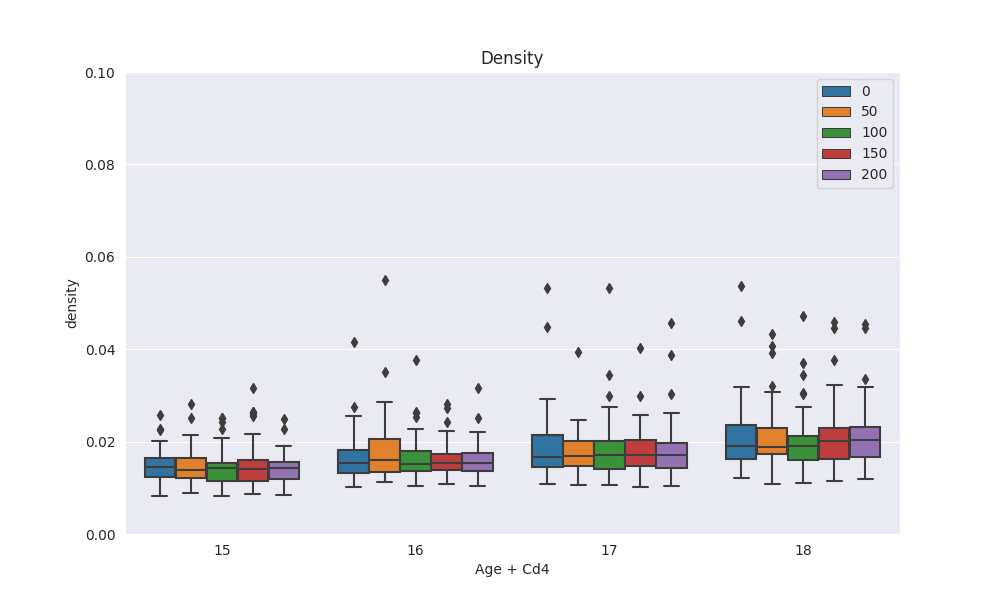

In [78]:
plt.figure(75, figsize=(10, 6))
sns.boxplot(data=density_melted, x='Age', y='value', hue='Cd4')
plt.title('Density')
plt.xlabel('Age + Cd4')
plt.ylabel('density')
plt.ylim(0, 0.1)
plt.legend(loc='upper right')
plt.show()


<IPython.core.display.Javascript object>


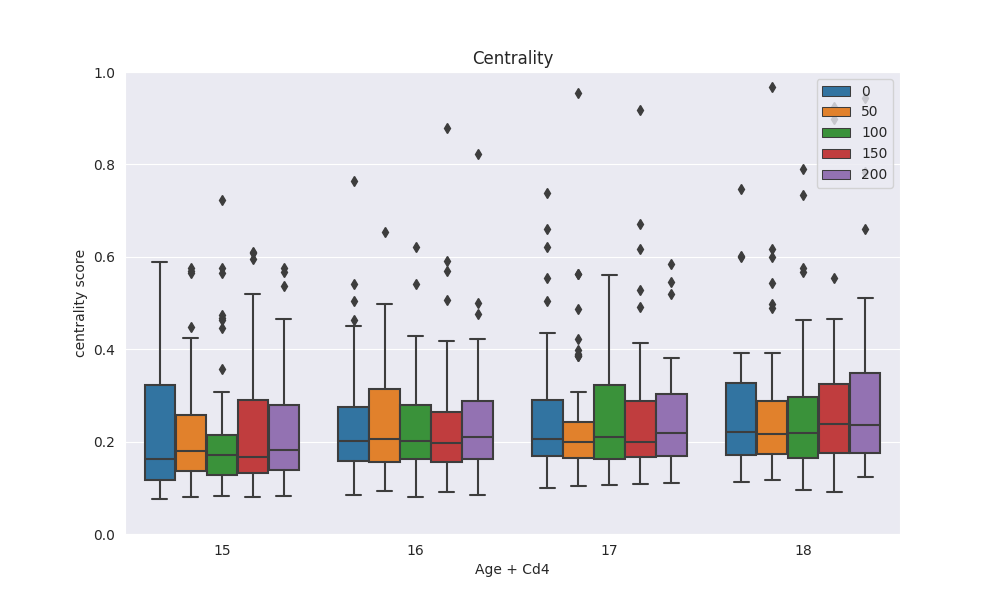

In [79]:
plt.figure(76, figsize=(10, 6))
sns.boxplot(data=centrality_melted, x='Age', y='value', hue='Cd4')
plt.title('Centrality')
plt.xlabel('Age + Cd4')
plt.ylabel('centrality score')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

<IPython.core.display.Javascript object>


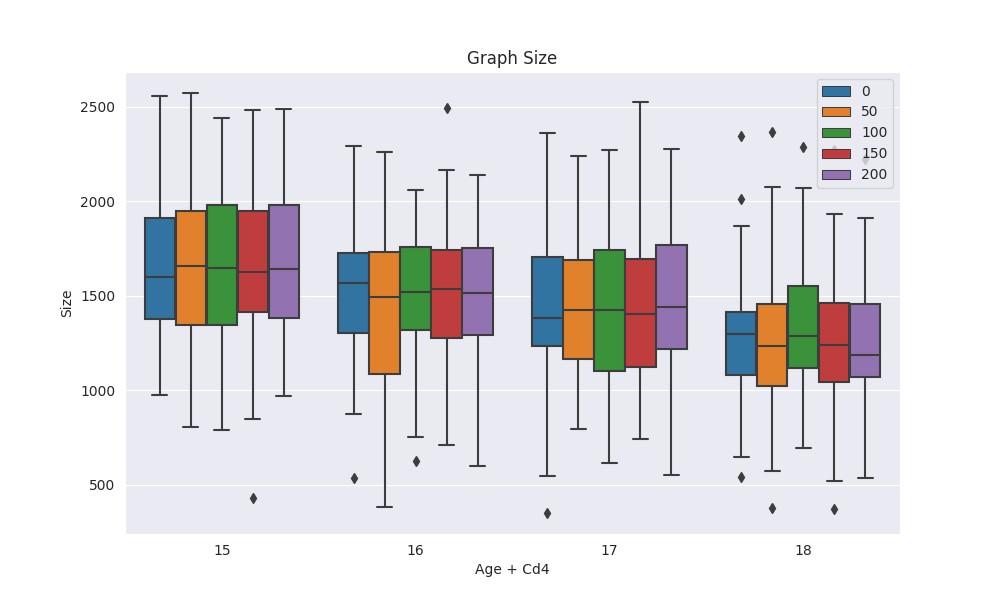

In [25]:
plt.figure(77, figsize=(10, 6))
sns.boxplot(data=Gsizes_melted, x='Age', y='value', hue='Cd4')
plt.title('Graph Size')
plt.xlabel('Age + Cd4')
plt.ylabel('Size')
plt.legend(loc='upper right')
plt.show()